In [1]:
import torch
from torch import Tensor, nn
from math import ceil
from torch.autograd import Function

```math
silu(x) = x * \sigma(x) = \frac{x}{1+e^{-x}}
```

In [2]:
def naive_silu(x:Tensor) -> Tensor:
    sigma = 1 / (1 + torch.exp(-x))
    return x * sigma

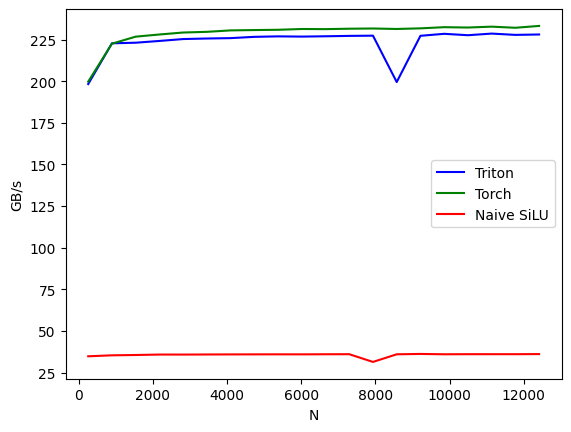

softmax-performance:
          N      Triton       Torch  Naive SiLU
0     256.0  198.297155  199.738847   34.763779
1     896.0  222.784333  222.558344   35.342444
2    1536.0  223.142159  226.784969   35.535460
3    2176.0  224.199578  228.083070   35.803001
4    2816.0  225.344369  229.263853   35.792121
5    3456.0  225.666776  229.677442   35.849403
6    4096.0  225.898020  230.542043   35.892775
7    4736.0  226.667673  230.746535   35.917672
8    5376.0  226.953862  230.909103   35.944663
9    6016.0  226.815876  231.381601   35.924768
10   6656.0  227.010180  231.301246   35.986854
11   7296.0  227.242555  231.552367   36.015214
12   7936.0  227.367665  231.682990   31.378247
13   8576.0  199.508566  231.396813   35.959919
14   9216.0  227.293445  231.773750   36.176894
15   9856.0  228.486157  232.470458   35.968881
16  10496.0  227.646872  232.266179   36.027474
17  11136.0  228.622866  232.790011   36.024432
18  11776.0  227.846457  232.118018   36.020758
19  12416.0  228.08

In [25]:
import triton
import triton.language as tl

DEVICE = torch.device('cuda')
import math


@triton.jit
def silu_kernel_fwd(x_poiter, act_pointer, sigma_pointer, num_elements, block_size: tl.constexpr):

    pid = tl.program_id(axis=0)
    pointers = pid*block_size + tl.arange(0, block_size)
    mask = pointers < num_elements

    x = tl.load(x_poiter+pointers, mask)
    # sigma = 1 / (1 + tl.exp(-x))
    # chunk_res = x * sigma
    chunk_res = x / (1 + tl.exp(-x))

    tl.store(act_pointer+pointers, chunk_res, mask)
    # tl.store(sigma_pointer+pointers, sigma, mask)


def silu_triton_fwd(x:Tensor, block_size:int=2048) -> Tensor:

    num_elements = x.numel()
    grid = ceil(num_elements / block_size),

    act = torch.empty_like(x).to(x.device)
    sigma = torch.empty_like(x).to(x.device)

    silu_kernel_fwd[grid](x, act, sigma, num_elements, block_size)
    return act#, sigma



### performance
x = torch.rand(100).to(DEVICE)
triton.testing.assert_close(silu_triton_fwd(x), naive_silu(x))

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 100, 5)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch', 'naive_silu'],  # possible values for `line_arg``
        line_names=["Triton", "Torch", "Naive SiLU"],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('red', '-')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(M, N, provider):
    x = torch.randn(M, N, device=DEVICE, dtype=torch.float32)
    stream = getattr(torch, DEVICE.type).Stream()
    getattr(torch, DEVICE.type).set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch.nn.functional.silu(x))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: silu_triton_fwd(x))
    if provider == 'naive_silu':
        ms = triton.testing.do_bench(lambda: naive_silu(x))
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms)


benchmark.run(show_plots=True, print_data=True)

In [26]:
layer = nn.SiLU()

class SiLUFunction(Function):
    @staticmethod
    def forward(ctx, x:Tensor) -> Tensor:
        sigma = 1 / (1 + torch.exp(-x))
        ctx.save_for_backward(x, sigma)
        return x * sigma

    @staticmethod
    def backward(ctx, grad_output):
        x, sigma,  = ctx.saved_tensors
        return grad_output * sigma * (1 + x * (1 - sigma))

class SiLUFunctionCustomModule(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor:
        in_shape = x.shape
        return SiLUFunction.apply(x.view(x.numel())).view(in_shape)

silu_custom = SiLUFunctionCustomModule()


In [27]:
### Check forward pass
x = torch.rand(8, 16, requires_grad=True)
assert torch.allclose(naive_silu(x), SiLUFunction.apply(x))


### Check backward pass
x = torch.rand(8, 16, requires_grad=True)

# Forward pass
out_a = silu_custom(x)
out_b = naive_silu(x)

grad_output = torch.randn_like(out_a)

# Backward pass A
grads_a, = torch.autograd.grad(out_a, (x), grad_outputs=grad_output, retain_graph=True)

# Backward pass B
grads_b, = torch.autograd.grad(out_b, (x), grad_outputs=grad_output, retain_graph=True)

for i, (ga, gb) in enumerate(zip(grads_a, grads_b)):
    max_diff = (ga - gb).abs().max().item()
    print(f"Gradient {i}: max diff = {max_diff}")
    assert torch.allclose(ga, gb, atol=1e-6), f"Mismatch in grad {i}"



Gradient 0: max diff = 1.1920928955078125e-07
Gradient 1: max diff = 5.960464477539063e-08
Gradient 2: max diff = 5.960464477539063e-08
Gradient 3: max diff = 1.1920928955078125e-07
Gradient 4: max diff = 1.1920928955078125e-07
Gradient 5: max diff = 2.384185791015625e-07
Gradient 6: max diff = 2.9802322387695312e-08
Gradient 7: max diff = 5.960464477539063e-08


In [42]:

@triton.jit
def silu_kernel_fwd(x_poiter, act_pointer, sigma_pointer, num_elements, block_size: tl.constexpr):

    pid = tl.program_id(axis=0)
    pointers = pid*block_size + tl.arange(0, block_size)
    mask = pointers < num_elements

    x = tl.load(x_poiter+pointers, mask)
    # sigma = 1 / (1 + tl.exp(-x))
    # chunk_res = x * sigma
    chunk_res = x / (1 + tl.exp(-x))

    tl.store(act_pointer+pointers, chunk_res, mask)
    # tl.store(sigma_pointer+pointers, sigma, mask)


def silu_triton_fwd(x:Tensor, block_size:int=2048) -> Tensor:

    num_elements = x.numel()
    grid = ceil(num_elements / block_size),

    act = torch.empty_like(x).to(x.device)
    sigma = torch.empty_like(x).to(x.device)

    silu_kernel_fwd[grid](x, act, sigma, num_elements, block_size)
    return act#, sigma



@triton.jit
def silu_kernel_bwd(
    x_pointer,
    # sigma_pointer,
    grad_output_pointer,
    dL_pointer,
    num_elements,
    block_size:tl.constexpr
):
    pid = tl.program_id(axis=0)

    pointer_offset = pid*block_size + tl.arange(0, block_size)
    mask = pointer_offset < num_elements

    grad_output = tl.load(grad_output_pointer+pointer_offset, mask)
    # sigma = tl.load(sigma_pointer+pointer_offset, mask)
    x = tl.load(x_pointer+pointer_offset, mask)

    sigma = 1 / (1 + tl.exp(-x))
    dL = grad_output * sigma * (1 + x * (1 - sigma))
    tl.store(dL_pointer+pointer_offset, dL, mask)


def silu_triton_bwd(x:Tensor, grad_output:Tensor, block_size:int=2048) -> Tensor:
    dL = torch.empty_like(grad_output)
    num_elements = dL.numel()
    grid = ceil(num_elements / block_size),
    silu_kernel_bwd[grid](x, grad_output, dL, num_elements, block_size)
    return dL


class SiLUFunctionTriton(Function):
    @staticmethod
    def forward(ctx, x:Tensor) -> Tensor:
        ctx.save_for_backward(x)
        x = silu_triton_fwd(x)
        return x

    @staticmethod
    def backward(ctx, grad_output):
        """ dL = grad_output * sigma * (1 + x * (1 - sigma)) """
        x, = ctx.saved_tensors
        dL = silu_triton_bwd(x, grad_output)
        return dL

class SiLUModuleTriton(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor:
        in_shape = x.shape
        return SiLUFunctionTriton.apply(x.view(x.numel())).view(in_shape)

silu_fun_triton = SiLUFunctionTriton.apply

In [44]:
### test that the results are correct
# input tensor
x = torch.rand(3, 4).to(DEVICE)
dy = torch.randn_like(x)
x.requires_grad = True

# fwd pass
act_torch = nn.functional.silu(x)
act_triton = SiLUFunctionTriton.apply(x)

# bkw pass (torch)
act_triton.backward(dy, retain_graph=True)
dx_triton  = x.grad.clone()
x.grad = None

# bwd pass (triton)
act_torch.backward(dy, retain_graph=True)
dx_torch  = x.grad.clone()

# compare
# print(dx_torch - dx_triton)
# print((dx_torch - dx_triton).norm()/dx_torch.norm())
assert torch.allclose(act_torch, act_triton, atol=1e-6, rtol=0)
assert torch.allclose(dx_triton, dx_torch, atol=1e-6, rtol=0)



### Compare performance
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],
        x_vals=[512 * i for i in range(2, 32)],
        line_arg='provider',
        line_vals=['triton', 'torch'] + (['apex'] if HAS_APEX else []),
        line_names=['Triton', 'Torch'] + (['Apex'] if HAS_APEX else []),
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],
        ylabel='GB/s',
        plot_name='layer-norm-backward',
        args={'M': 4096, 'dtype': torch.float16, 'mode': 'backward'},
    ))
def bench_layer_norm(M, N, dtype, provider, mode='backward', eps=1e-5, device=DEVICE):
    # create data
    x_shape = (M, N)
    w_shape = (x_shape[-1], )
    weight = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    bias = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    x = -2.3 + 0.5 * torch.randn(x_shape, dtype=dtype, device=device)
    dy = .1 * torch.randn_like(x)
    x.requires_grad_(True)
    quantiles = [0.5, 0.2, 0.8]

    def y_fwd():

        if provider == "triton":
            return silu_fun_triton(x, w_shape, weight, bias, eps)  # noqa: F811, E704

        if provider == "torch":
            return torch.nn.functional.silu(x, w_shape, weight, bias, eps)  # noqa: F811, E704

    # forward pass
    if mode == 'forward':
        gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
        ms, min_ms, max_ms = triton.testing.do_bench(y_fwd, quantiles=quantiles, rep=500)
    # backward pass
    if mode == 'backward':
        y = y_fwd()
        gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)  # noqa: F811, E704
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), quantiles=quantiles,
                                                     grad_to_none=[x], rep=500)
    return gbps(ms), gbps(max_ms), gbps(min_ms)


test_layer_norm(1151, 8192, torch.float16)
bench_layer_norm.run(save_path='.', print_data=True)

benchmark.run(show_plots=True, print_data=True)

Testing mode: backward


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn